In [2]:
import pandas as pd
import numpy as np

emissions_df = pd.read_csv('state_emissions.csv')
energy_df = pd.read_csv('state_wise_energy_all_sectors.csv')
temperature_df = pd.read_csv('temperature_data_2023.csv')

## Method
The research aims to estimate the causal effect of increased electricity demand on carbon emissions across different U.S. states and throughout various times of the year. The treatment variable, electricity demand, is measured in megawatt-hours, while the outcome variable, carbon emissions, is measured in metric tons of CO2. \
**Treatment Variable:** Electricity demand. This is expected to be a primary driver of emissions, as higher demand often leads to greater electricity generation, potentially from carbon-intensive sources. \
**Outcome Variable:** Carbon emission levels. This represents the environmental impact associated with increased electricity demand. \
**Units of Analysis:** State-month observations, where each data point corresponds to a state (California) in a specific month. \
**Confounders:** Economic activity, state energy policies, demographic factors... \
**Instrumental Variable:** Temperature extremes. Temperature affects electricity demand, particularly during extreme heat or cold, as people use more electricity for heating or cooling.



In [3]:
emissions_df.head()

period stateid stateDescription fuelid fuelDescription  co2-rate-lbs-mwh  \
0    2023      AZ          Arizona    COL            Coal               NaN   
1    2023      WY          Wyoming    ALL           Total            1864.0   
2    2023      WY          Wyoming    PET       Petroleum               NaN   
3    2023      WY          Wyoming    OTH           Other               NaN   
4    2023      WY          Wyoming     NG     Natural Gas               NaN   

   co2-thousand-metric-tons  nox-rate-lbs-mwh  nox-short-tons  \
0                     12863               NaN            9238   
1                     36580               1.4           31178   
2                        37               NaN              22   
3                         0               NaN            3436   
4                      1516               NaN            2489   

   so2-rate-lbs-mwh  so2-short-tons   co2-rate-lbs-mwh-units  \
0               NaN            6854  pounds per megawatthour   
1               1.1           24209  pounds per megawatthour   
2               NaN              13  pounds per megawatthour   
3               NaN               8  pounds per megawatthour   
4               NaN               9  pounds per megawatthour   

  co2-thousand-metric-tons-units   nox-rate-lbs-mwh-units  \
0           thousand metric tons  pounds per megawatthour   
1           thousand metric tons  pounds per megawatthour   
2           thousand metric tons  pounds per megawatthour   
3           thousand metric tons  pounds per megawatthour   
4           thousand metric tons  pounds per megawatthour   

  nox-short-tons-units   so2-rate-lbs-mwh-units so2-short-tons-units  
0           short tons  pounds per megawatthour           short tons  
1           short tons  pounds per megawatthour           short tons  
2           short tons  pounds per megawatthour           short tons  
3           short tons  pounds per megawatthour           short tons  
4           short tons  pounds per megawatthour           short tons

#### Filter and clean 2023 CO2 emissions data in California

In [4]:
ca_emissions = emissions_df[emissions_df['stateid'] == 'CA']
ca_2023_emissions = ca_emissions[ca_emissions['period'] == 2023]
ca_2023_emissions_clean = ca_2023_emissions[
    (ca_2023_emissions['stateid'] == 'CA') &
    (ca_2023_emissions['fuelid'] == 'ALL')
][['period', 'co2-thousand-metric-tons']]

print("Cleaned emissions data:")
print(ca_2023_emissions_clean)
print("\nData types:")
print(ca_2023_emissions_clean.dtypes)

Cleaned emissions data:
     period  co2-thousand-metric-tons
240    2023                     43360

Data types:
period                      int64
co2-thousand-metric-tons    int64
dtype: object


In [5]:
ca_2023_emissions_clean

period  co2-thousand-metric-tons
240    2023                     43360

In [6]:
all_months = pd.date_range(start='2023-01-01', end='2023-12-31', freq='M')
all_months_df = pd.DataFrame({'month': all_months.strftime('%Y-%m')})
all_months_df.head()

month
0  2023-01
1  2023-02
2  2023-03
3  2023-04
4  2023-05

In [7]:
temperature_df.head()

date datatype            station attributes  value
0  2023-01-01     TAVG  GHCND:USR0000CABS       ,,U,     64
1  2023-01-01     TAVG  GHCND:USR0000CSFD       ,,U,    123
2  2023-01-01     TAVG  GHCND:USR0000CSEC       ,,U,     45
3  2023-01-01     TAVG  GHCND:USR0000CSDD       ,,U,    -54
4  2023-01-01     TAVG  GHCND:USR0000CSDC       ,,U,     29

In [8]:
# Convert to Celsius and handle missing months
temperature_df['month'] = temperature_df['date'].apply(lambda x: x[:7])
monthly_temp = temperature_df[['month', 'value']].groupby('month').mean()
monthly_temp['value'] = (monthly_temp['value'] - 32) * 5/9  # Convert F to C

# Create a complete month range
all_months = pd.date_range(start='2023-01-01', end='2023-12-31', freq='M')
all_months_df = pd.DataFrame({'month': all_months.strftime('%Y-%m')})

monthly_temp_complete = pd.merge(all_months_df, monthly_temp, on='month', how='left')

print("Monthly average temperatures (Celsius):")
print(monthly_temp_complete)
print("\nMissing months:")
print(monthly_temp_complete[monthly_temp_complete['value'].isna()])

Monthly average temperatures (Celsius):
      month       value
0   2023-01    6.022309
1   2023-02    5.218220
2   2023-03    8.954648
3   2023-04   40.973069
4   2023-05   59.024418
5   2023-06   74.128738
6   2023-07  113.862444
7   2023-08  103.899591
8   2023-09   79.073974
9   2023-10   64.043716
10  2023-11   35.190453
11  2023-12   25.527321

Missing months:
Empty DataFrame
Columns: [month, value]
Index: []


In [9]:
# Check energy data
print("Energy consumption data:")
print(energy_df[energy_df['stateid'] == 'CA'][['period', 'sales']].head(12))
print("\nData types:")
print(energy_df.dtypes)

Energy consumption data:
     period        sales
0   2024-01  20040.74935
1   2023-12  18660.12634
2   2023-11  18479.20564
3   2023-10  20390.47299
4   2023-09  22466.03859
5   2023-08  25101.55563
6   2023-07  23048.26218
7   2023-06  19333.43379
8   2023-05  18288.41200
9   2023-04  16261.33366
10  2023-03  19506.41869
11  2023-02  17440.48579

Data types:
period               object
stateid              object
stateDescription     object
sectorid             object
sectorName           object
sales               float64
sales-units          object
dtype: object


#### Prepare a final dataset for analyzing the relationship between temperature, energy demand, and emissions in 2023 California

In [10]:
# only include 2023
energy_clean = energy_df[
    (energy_df['stateid'] == 'CA') &
    (energy_df['period'].str.startswith('2023'))
].copy()

energy_clean['month'] = pd.to_datetime(energy_clean['period']).dt.strftime('%Y-%m')
final_df = pd.merge(monthly_temp, energy_clean[['month', 'sales']], on='month')
final_df = final_df.rename(columns={'value': 'temperature', 'sales': 'energy_demand'})

final_df['emissions'] = ca_2023_emissions_clean['co2-thousand-metric-tons'].values[0] / 12

print("Final dataset for causal analysis:")
print(final_df)
print("\nData types:")
print(final_df.dtypes)

# Basic correlations
print("\nCorrelations:")
print(final_df[['temperature', 'energy_demand', 'emissions']].corr())

Final dataset for causal analysis:
      month  temperature  energy_demand    emissions
0   2023-01     6.022309    20504.70675  3613.333333
1   2023-02     5.218220    17440.48579  3613.333333
2   2023-03     8.954648    19506.41869  3613.333333
3   2023-04    40.973069    16261.33366  3613.333333
4   2023-05    59.024418    18288.41200  3613.333333
5   2023-06    74.128738    19333.43379  3613.333333
6   2023-07   113.862444    23048.26218  3613.333333
7   2023-08   103.899591    25101.55563  3613.333333
8   2023-09    79.073974    22466.03859  3613.333333
9   2023-10    64.043716    20390.47299  3613.333333
10  2023-11    35.190453    18479.20564  3613.333333
11  2023-12    25.527321    18660.12634  3613.333333

Data types:
month             object
temperature      float64
energy_demand    float64
emissions        float64
dtype: object

Correlations:
               temperature  energy_demand  emissions
temperature       1.000000       0.695788        NaN
energy_demand     0.695788  

#### Analysis of the relationship between temperature and energy demand using linear regression

First Stage Results (Temperature -> Energy Demand):
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.753e+04    963.128     18.203      0.000    1.54e+04    1.97e+04
temperature    47.2421     15.421      3.063      0.012      12.881      81.603


/Users/areeyatipyasothi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


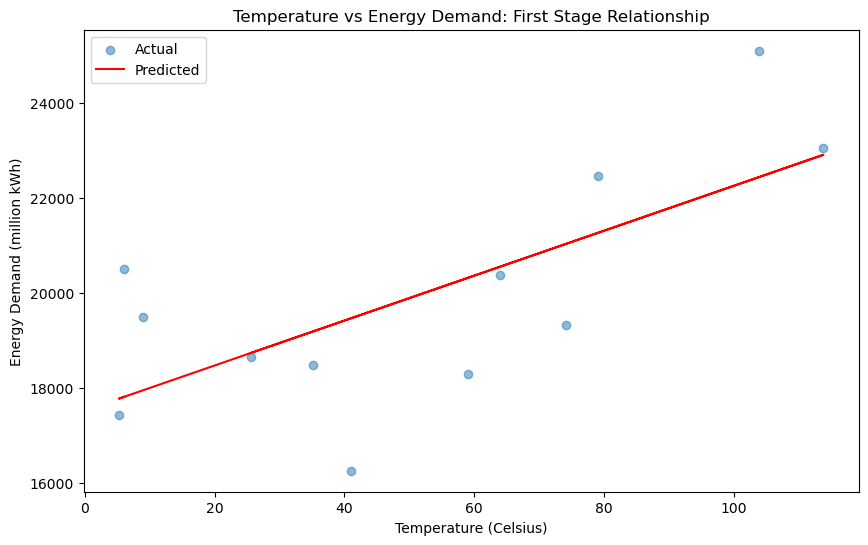

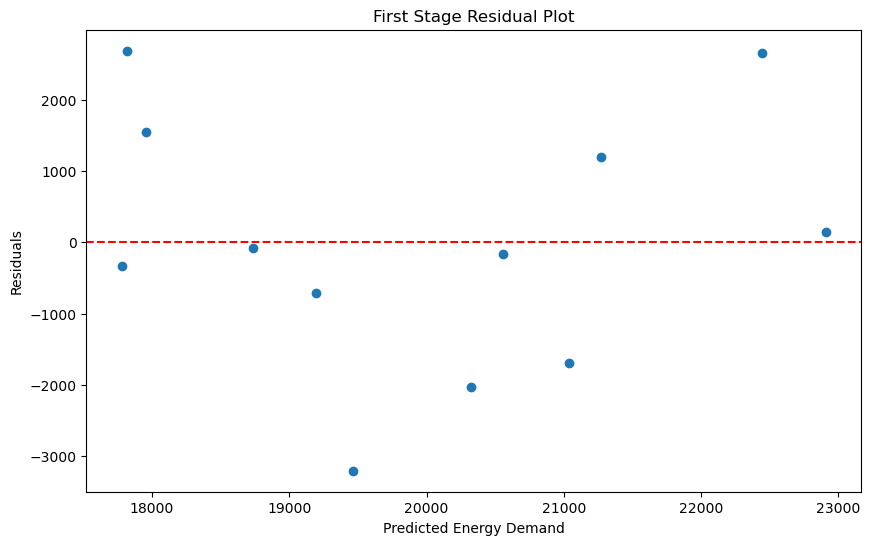

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

X_first = sm.add_constant(final_df['temperature'])
first_stage = sm.OLS(final_df['energy_demand'], X_first).fit()

energy_demand_predicted = first_stage.predict(X_first)

print("First Stage Results (Temperature -> Energy Demand):")
print(first_stage.summary().tables[1])

import matplotlib.pyplot as plt

# Plot actual vs predicted energy demand
plt.figure(figsize=(10, 6))
plt.scatter(final_df['temperature'], final_df['energy_demand'], alpha=0.5, label='Actual')
plt.plot(final_df['temperature'], energy_demand_predicted, color='red', label='Predicted')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Energy Demand (million kWh)')
plt.title('Temperature vs Energy Demand: First Stage Relationship')
plt.legend()
plt.show()

# Plot residuals
residuals = first_stage.resid
plt.figure(figsize=(10, 6))
plt.scatter(energy_demand_predicted, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Energy Demand')
plt.ylabel('Residuals')
plt.title('First Stage Residual Plot')
plt.show()

In [12]:
# Second stage regression
X_second = sm.add_constant(energy_demand_predicted)
second_stage = sm.OLS(final_df['emissions'], X_second).fit()
print(second_stage.summary())

                            OLS Regression Results                            
Dep. Variable:              emissions   R-squared:                      -8.000
Model:                            OLS   Adj. R-squared:                 -8.900
Method:                 Least Squares   F-statistic:                    -8.889
Date:                Fri, 06 Dec 2024   Prob (F-statistic):               1.00
Time:                        22:30:33   Log-Likelihood:                 310.82
No. Observations:                  12   AIC:                            -617.6
Df Residuals:                      10   BIC:                            -616.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3613.3333   5.14e-12   7.03e+14      0.0

/Users/areeyatipyasothi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/areeyatipyasothi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/areeyatipyasothi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1667: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/areeyatipyasothi/opt/anaconda3/lib/python3.9/site-packages/scipy/sta

## Results
Based on the first-stage regression results (independent variable: temperature; dependent variable: energy demand), higher temperatures are associated with increased energy consumption. \
However, the second-stage regression results indicate a constant value for the emissions data. The R-squared value is negative, showing that the model performs worse than a simple mean prediction, meaning a poor explanatory power for the model. This result may be due to the fact that the monthly emission data are large values, leading to low variability.

In [13]:
# Distribute annual emissions based on energy demand
total_energy = energy_clean['sales'].sum()  # Total energy demand for 2023
final_df['emissions'] = final_df['energy_demand'] / total_energy * ca_2023_emissions_clean['co2-thousand-metric-tons'].values[0]

print("Updated emissions data:")
print(final_df[['month', 'emissions']])

Updated emissions data:
      month    emissions
0   2023-01  3712.553894
1   2023-02  3157.750277
2   2023-03  3531.805236
3   2023-04  2944.254621
4   2023-05  3311.274626
5   2023-06  3500.484829
6   2023-07  4173.086528
7   2023-08  4544.853005
8   2023-09  4067.669928
9   2023-10  3691.870887
10  2023-11  3345.819459
11  2023-12  3378.576711


### A refined model to account for non-linear effects

In [14]:
# Add squared temperature term for non-linear effects
final_df['temperature_squared'] = final_df['temperature'] ** (2)

# First-stage regression (include non-linear term)
X_first = sm.add_constant(final_df[['temperature', 'temperature_squared']])
first_stage_square = sm.OLS(final_df['energy_demand'], X_first).fit()

# Predict energy demand
final_df['energy_demand_predicted_square'] = first_stage_square.predict(X_first)

# Second-stage regression
X_second = sm.add_constant(final_df['energy_demand_predicted_square'])
second_stage = sm.OLS(final_df['emissions'], X_second).fit()

# Print results
print("Second Stage Results (Energy Demand -> Emissions):")
print(second_stage.summary())

Second Stage Results (Energy Demand -> Emissions):
                            OLS Regression Results                            
Dep. Variable:              emissions   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     21.35
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           0.000949
Time:                        22:30:33   Log-Likelihood:                -83.142
No. Observations:                  12   AIC:                             170.3
Df Residuals:                      10   BIC:                             171.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

/Users/areeyatipyasothi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


This refined model is much more explanatory. The energy demand coefficient is 0.1811, meaning each additional unit of predicted energy demand corresponds to a 0.1811 unit increase in emissions. This result suggests a linear relationship between higher energy demand and increased emissions.

In [20]:
# Add squared temperature term for non-linear effects
final_df['temperature_sqrt'] = final_df['temperature'] ** (1/2)

# First-stage regression (include non-linear term)
X_first = sm.add_constant(final_df[['temperature', 'temperature_squared']])
first_stage_sqrt = sm.OLS(final_df['energy_demand'], X_first).fit()

# Predict energy demand
final_df['energy_demand_predicted_sqrt'] = first_stage_sqrt.predict(X_first)

# Second-stage regression
X_second = sm.add_constant(final_df['energy_demand_predicted_sqrt'])
second_stage = sm.OLS(final_df['emissions'], X_second).fit()

# Print results
print("Second Stage Results (Energy Demand -> Emissions):")
print(second_stage.summary())

Second Stage Results (Energy Demand -> Emissions):
                            OLS Regression Results                            
Dep. Variable:              emissions   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     21.35
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           0.000949
Time:                        22:33:59   Log-Likelihood:                -83.142
No. Observations:                  12   AIC:                             170.3
Df Residuals:                      10   BIC:                             171.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

/Users/areeyatipyasothi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [21]:
# Add squared temperature term for non-linear effects
final_df['temperature_exp'] = np.exp(final_df['temperature']) 

# First-stage regression (include non-linear term)
X_first = sm.add_constant(final_df[['temperature', 'temperature_squared']])
first_stage_exp = sm.OLS(final_df['energy_demand'], X_first).fit()

# Predict energy demand
final_df['energy_demand_predicted_exp'] = first_stage.predict(X_first)

# Second-stage regression
X_second = sm.add_constant(final_df['energy_demand_predicted_exp'])
second_stage = sm.OLS(final_df['emissions'], X_second).fit()

# Print results
print("Second Stage Results (Energy Demand -> Emissions):")
print(second_stage.summary())

Second Stage Results (Energy Demand -> Emissions):
                            OLS Regression Results                            
Dep. Variable:              emissions   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     21.35
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           0.000949
Time:                        22:34:14   Log-Likelihood:                -83.142
No. Observations:                  12   AIC:                             170.3
Df Residuals:                      10   BIC:                             171.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

/Users/areeyatipyasothi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [22]:
# Add squared temperature term for non-linear effects
final_df['temperature_log'] = np.log(final_df['temperature'])

# First-stage regression (include non-linear term)
X_first = sm.add_constant(final_df[['temperature', 'temperature_squared']])
first_stage_log = sm.OLS(final_df['energy_demand'], X_first).fit()

# Predict energy demand
final_df['energy_demand_predicted_log'] = first_stage_log.predict(X_first)

# Second-stage regression
X_second = sm.add_constant(final_df['energy_demand_predicted_log'])
second_stage = sm.OLS(final_df['emissions'], X_second).fit()

# Print results
print("Second Stage Results (Energy Demand -> Emissions):")
print(second_stage.summary())

Second Stage Results (Energy Demand -> Emissions):
                            OLS Regression Results                            
Dep. Variable:              emissions   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     21.35
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           0.000949
Time:                        22:34:23   Log-Likelihood:                -83.142
No. Observations:                  12   AIC:                             170.3
Df Residuals:                      10   BIC:                             171.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

/Users/areeyatipyasothi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [23]:
# First-stage regression (include non-linear term)
first_stage= sm.OLS(final_df['energy_demand'], X_first).fit()

# Predict energy demand
final_df['energy_demand_predicted'] = first_stage.predict(X_first)

# Second-stage regression
X_second = sm.add_constant(final_df['energy_demand_predicted_log'])
second_stage = sm.OLS(final_df['emissions'], X_second).fit()

# Print results
print("Second Stage Results (Energy Demand -> Emissions):")
print(second_stage.summary())

Second Stage Results (Energy Demand -> Emissions):
                            OLS Regression Results                            
Dep. Variable:              emissions   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     21.35
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           0.000949
Time:                        22:34:35   Log-Likelihood:                -83.142
No. Observations:                  12   AIC:                             170.3
Df Residuals:                      10   BIC:                             171.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

/Users/areeyatipyasothi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


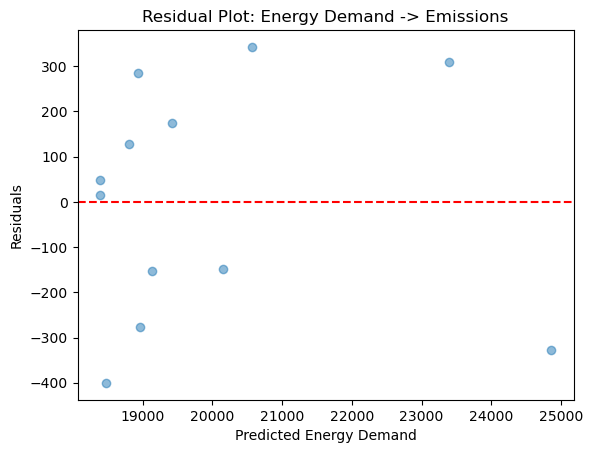

Breusch-Pagan Test Results: (1.872583007901873, 0.17117953739248581, 1.8490233090658243, 0.20376457780510587)


In [24]:
# Residuals of second stage
residuals = second_stage.resid

# Residual plot
plt.scatter(final_df['energy_demand_predicted'], residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Energy Demand')
plt.ylabel('Residuals')
plt.title('Residual Plot: Energy Demand -> Emissions')
plt.show()

# Breusch-Pagan test
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(residuals, X_second)
print("Breusch-Pagan Test Results:", bp_test)


<Figure size 1000x600 with 0 Axes>

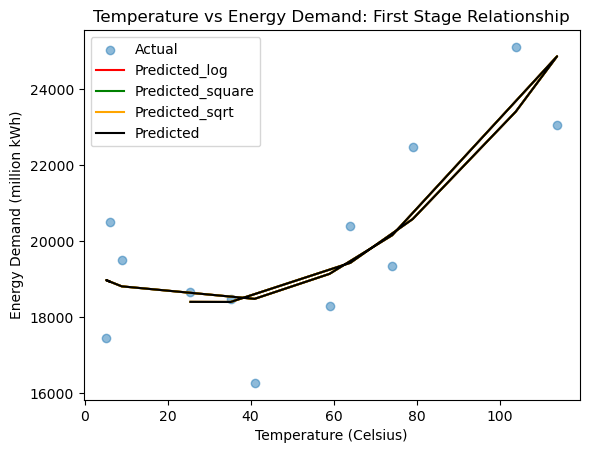

In [25]:
# Plot actual vs predicted energy demand
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
ax.scatter(final_df['temperature'], final_df['energy_demand'], alpha=0.5, label='Actual')
ax.plot(final_df['temperature'], final_df['energy_demand_predicted_log'], color='red', label='Predicted_log')
ax.plot(final_df['temperature'], final_df['energy_demand_predicted_square'], color='green', label='Predicted_square')
ax.plot(final_df['temperature'], final_df['energy_demand_predicted_sqrt'], color='orange', label='Predicted_sqrt')
ax.plot(final_df['temperature'], final_df['energy_demand_predicted'], color='black', label='Predicted')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Energy Demand (million kWh)')
plt.title('Temperature vs Energy Demand: First Stage Relationship')
plt.legend()
plt.show()

From our first stage model, we were able to see that some positive relationship between energy demand and temperature existed. We were able to find a better fitting model by using the square root of energy demand vs temperature, which we can clearly see performs better as indicated by the AIC and BIC and the slightly higher log-likelihood. 

There are limitations in our method, as we are extrapolating the emissions based on demand over the whole year. This does not take into account the possibility of energy prodution efficiency being different across different months (ie some months having a higher proportion created by renewable energy), and it does not fully dicount the confounder of seasonal changes in temperature. In addition, we have not taken into account the vast space and spread out nature of California, and the nonuniform nature of emissions across the state. Furthermore we are unable to account for levels of industrial activity through the state. Thus some next steps we will take is using the disaggregated time and place data which will potentially allow us to account for these changes in temperature as well as industrial impact across the state. We can also isolate times were the temperature rises above a certain level and compare energy use during those times to similar periods where there are more average temperatures. 

However our inital results do tell us as temperature increases, the demand for energy increases. Due to this, we can recommend having reserves or alternatives to energy use during times of high temperature as to reduce stress on the grid. 

### Try a Random Forest model

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

X = final_df[['temperature', 'temperature_squared', 'energy_demand_predicted_square']]
y = final_df['emissions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print("Feature Importances:")
print(rf.feature_importances_)

Mean Squared Error: 116714.27204900718
R-squared: -3.124607998474173
Feature Importances:
[0.35727305 0.35349779 0.28922915]


The negative R-square value suggests that the Random Forest model could not explain the variability of the emissions. And the large mean square error shows that the model bias is high. Therefore, this model performs worse than the previous linear model.

## DAG of the variables

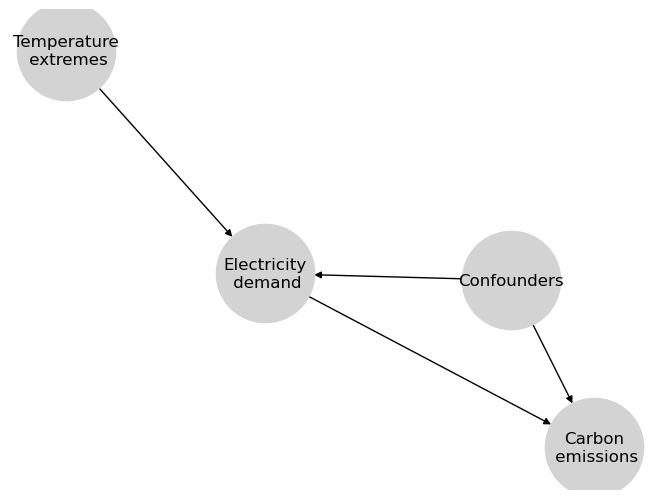

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

# Create causal dag
cg = nx.DiGraph()
# Variable strings
elde = 'Electricity\n demand'
caem = 'Carbon\n emissions'
temex = 'Temperature\n extremes'
#confounders
ecac = 'Economic\nActivity'
enpo = 'Energy\npolicies'
inim = 'Industrial\nimpact'
cg.add_edges_from([(elde, caem), (temex, elde), ('Confounders',elde),('Confounders',caem)])
nx.draw(cg, with_labels=True,node_size=5000, node_color='lightgray')